#### Download Required Scripts

In [1]:
!wget -q https://raw.githubusercontent.com/ppkgtmm/ds-projects/main/deep-learning/sentiment-analysis/preprocessor.py
!wget -q https://raw.githubusercontent.com/ppkgtmm/ds-projects/main/deep-learning/sentiment-analysis/data_reader.py

#### Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS
import pickle
from preprocessor import Preprocessor
from data_reader import get_labels_and_texts
import numpy as np

plt.style.use('fivethirtyeight')

#### Read Data
- data was originally in compressed text file format
- there exist a separate test which have true labels

In [3]:
train_size = 1e5
test_size = 3e3

train_labels, train_texts = get_labels_and_texts('../input/train.ft.txt.bz2', train_size)
test_labels, test_texts = get_labels_and_texts('../input/test.ft.txt.bz2', test_size)

In [4]:
train = pd.DataFrame({
    'target': train_labels,
    'text': train_texts,
})

test = pd.DataFrame({
    'target': test_labels,
    'text': test_texts,
})

train.head()

,target,text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


#### Preprocessing
- instantiate preprocessor comprised of 
    - html tags, punctuation removal
    - number, email, url normalization
    - abbreviated word expansion
- apply preprocessor on sample text

In [5]:
prep = Preprocessor()
apply_prep = lambda x: prep.preprocess(x)
print("Before preprocessing")
display(train.iloc[2:3,-1].values[0])

print("\nAfter preprocessing")
display(train.iloc[2:3,-1].apply(apply_prep).values[0])

Before preprocessing


'Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer\'s work (I haven\'t heard the Xenogears soundtrack, so I can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.'


After preprocessing


'amazing this soundtrack is my favorite music of all time hands down the intense sadness of prisoners of fate which means all the more if you have played the game and the hope in a distant promise and girl who stole the star have been an important inspiration to me personally throughout my teen years the higher energy tracks like chrono cross time scar time of the dreamwatch and chronomantique indefinably remeniscent of chrono trigger are all absolutely superb as well this soundtrack is amazing music probably the best of this composer work i have not heard the xenogears soundtrack so i can not say for sure and even if you have never played the game it would be worth twice the price to buy it i wish i could give it NUMBER stars'

- actual text data preprocessing

In [6]:
train['text'] = train['text'].apply(apply_prep)
test['text'] = test['text'].apply(apply_prep)

- transform target from integer to string for ease of use

In [7]:
sentiment_map = {0: "negative", 1: "positive"}
target_mapper = lambda x: sentiment_map[x]

train['target'] = train['target'].apply(target_mapper)
test['target'] = test['target'].apply(target_mapper)

#### Save Data

In [8]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

#### Data Visualization

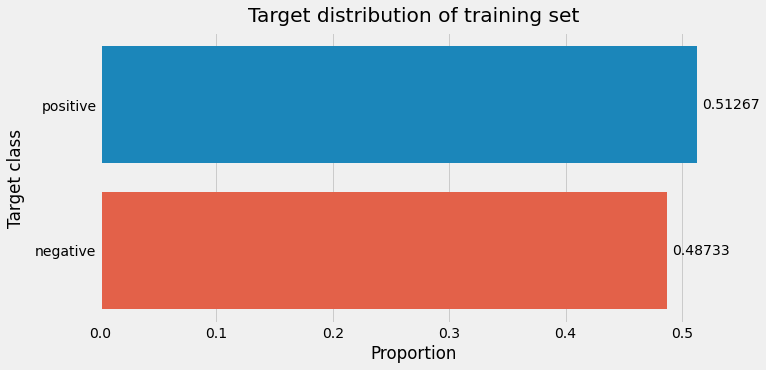

In [9]:
label_dist = train['target'].value_counts(normalize=True)

plt.figure(figsize=(10,5))
ax = sns.barplot(y=label_dist.index, x=label_dist, orient='h')
ax.bar_label(ax.containers[0], padding=5)
plt.title('Target distribution of training set', pad=10)
plt.xlabel('Proportion')
plt.ylabel('Target class', labelpad=10)
plt.show()

- positive text examples proportion leads negative examples by 3 % of difference 

In [10]:
positive_texts = train.query('target == "positive"')["text"]
negative_texts = train.query('target == "negative"')["text"]

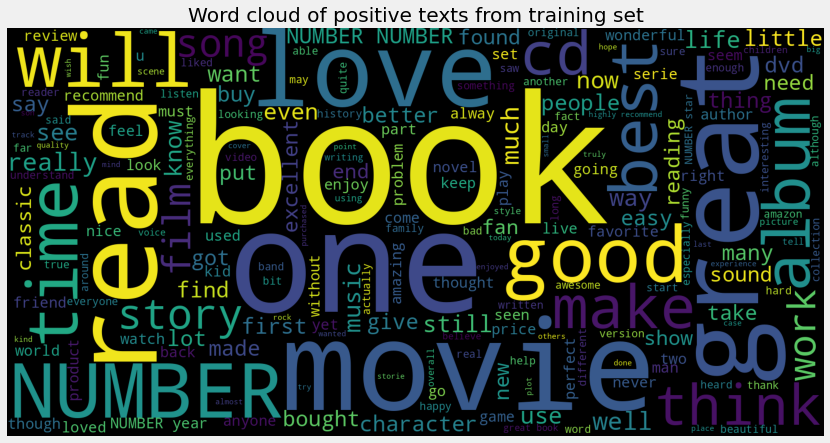

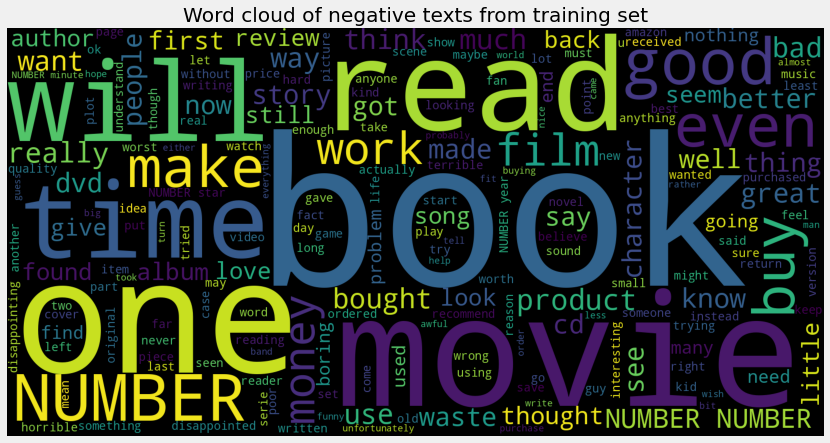

In [11]:
def plot_wordcloud(texts, title):
    wordcloud = WordCloud(stopwords=STOPWORDS, width=1600, height=800).generate(" ".join(texts))
    plt.figure(figsize=(14,7))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

plot_wordcloud(positive_texts, 'Word cloud of positive texts from training set')
plot_wordcloud(negative_texts, 'Word cloud of negative texts from training set')

- there are high frequency of product related words in both text groups
- words that can express polarity of text e.g. good, love, waste, bad are also seen in the word clouds

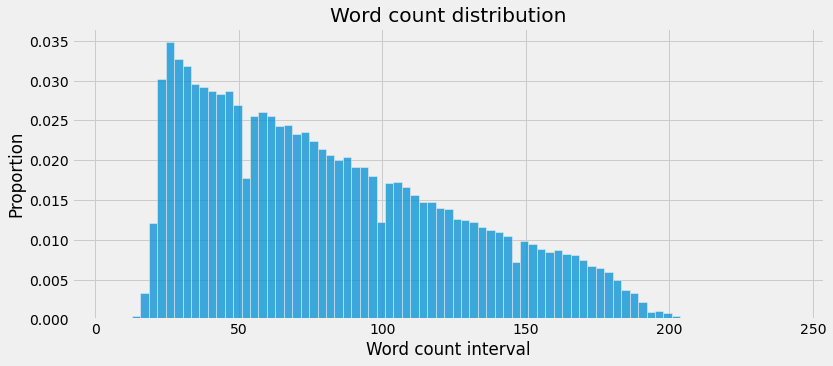

In [12]:
plt.figure(figsize=(12,5))
sns.histplot(pd.Series(map(lambda x: len(x.split()), train['text'].values)), stat="proportion")
plt.title('Word count distribution')
plt.xlabel('Word count interval')
plt.show()

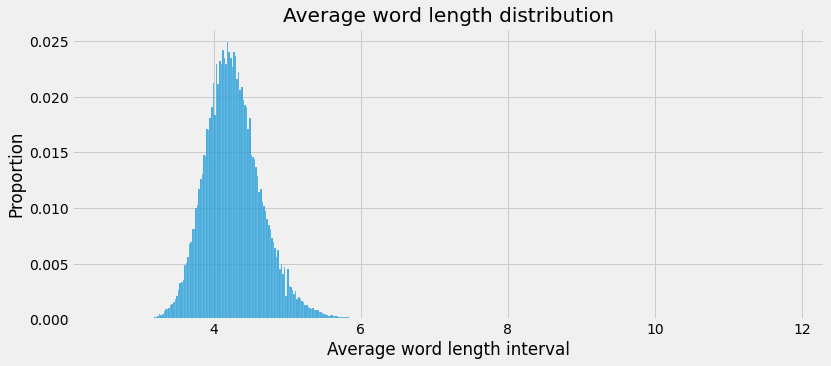

In [13]:
get_avg_word_len = lambda x: np.average([len(word) for word in x.split()])
plt.figure(figsize=(12,5))
sns.histplot(pd.Series(map(lambda x: get_avg_word_len(x), train['text'].values)), stat="proportion")
plt.title('Average word length distribution')
plt.xlabel('Average word length interval')
plt.show()

In [14]:
MAX_FEATURES = 15e3

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES, oov_token='<UNK>')
tokenizer.fit_on_texts(train['text'].values)

pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))